## PDF Shaping - Tuyere (396 samples)

The model consists of the sum of a linear function and a non-linear function with PDF shaping.

This model uses the CFD Tuyere data with 396 samples.

## Web application 4 inputs and 2 outputs

Run interactively on the web at: https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/september2022/396samples/s396TuyerePDFshaping/index.html

## Inputs

(1, 'i_pul_coal_inj_kg_thm')

(2, 'i_nat_gas_inj_kg_thm')

(3, 'i_nat_gas_t_k')

(4, 'i_o2_vol_perce')



## Outputs

(13, 'o_tuyere_exit_velo_m_s')

(14, 'o_tuyere_t_k')



In [4]:
################################################
##
## regression with ML for system control
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################
## learning_rate_mse        = 0.0005
## probably needs adjustable learning rate scheduler


N_EPOCHS = 10000                            ## 4000
batch_size = 16                             ## 5    ## 32
learning_rate =  0.1                        ## 0.01   ## 1e-5 


## 0.0001  experimentally seemed okay 
learning_rate_pdfcontrol  =  0.0001     ## 0.00001       ## 0.000001


#######################################################
# define mean and standard deviation of target Gaussian distribution (impulse function)

mean_impulse = 0.
std_impulse  = 0.01


## experimentally 0.5 - 0.7 was interesting
h = 0.7            ## 0.05     ## 0.03                    ## 0.05 >


## experimentally 20 seemed okay 
N_error_range = 20          ## 20  ## 10   ## error between pred and real range (-20, 20)

switch_threshold = 0.90

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [5]:
CFD_raw_data = pd.read_csv('396.CFD.8.2022.csv')

In [6]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['index', 'i_pul_coal_inj_kg_thm', 'i_nat_gas_inj_kg_thm', 'i_nat_gas_t_k', 'i_o2_vol_perce', 'i_bf_windrate_nm3_hr', 'i_hb_moist_g_nm3', 'i_hot_blast_press_pa', 'i_hot_blast_temp_k', 'i_ore_moisture_weight_perce', 'i_coke_weight_kg', 'i_ore_weight_kg', 'o_production_rate_thmperday', 'o_tuyere_exit_velo_m_s', 'o_tuyere_t_k', 'o_raceway_flame_temp_k', 'o_raceway_coal_burn_perce', 'o_raceway_volume_m', 'o_raceway_depth_m', 'o_shaft_co_utiliz', 'o_shaft_h2_utiliz', 'o_shaft_top_gas_temp_c', 'o_shaft_press_drop_pa', 'o_shaft_coke_rate_kg_thm', 'o_shaft_cohesive_zone_tip_height_m', 'o_shaft_co_v_perc', 'o_shaft_co2_v_perc', 'o_shaft_h2_v_perce', 'o_shaft_n2_v_perc']
29
(0, 'index')
(1, 'i_pul_coal_inj_kg_thm')
(2, 'i_nat_gas_inj_kg_thm')
(3, 'i_nat_gas_t_k')
(4, 'i_o2_vol_perce')
(5, 'i_bf_windrate_nm3_hr')
(6, 'i_hb_moist_g_nm3')
(7, 'i_hot_blast_press_pa')
(8, 'i_hot_blast_temp_k')
(9, 'i_ore_moisture_weight_perce')
(10, 'i_coke_weight_kg')
(11, 'i_ore_weight_kg')
(12, 'o_production_rate_

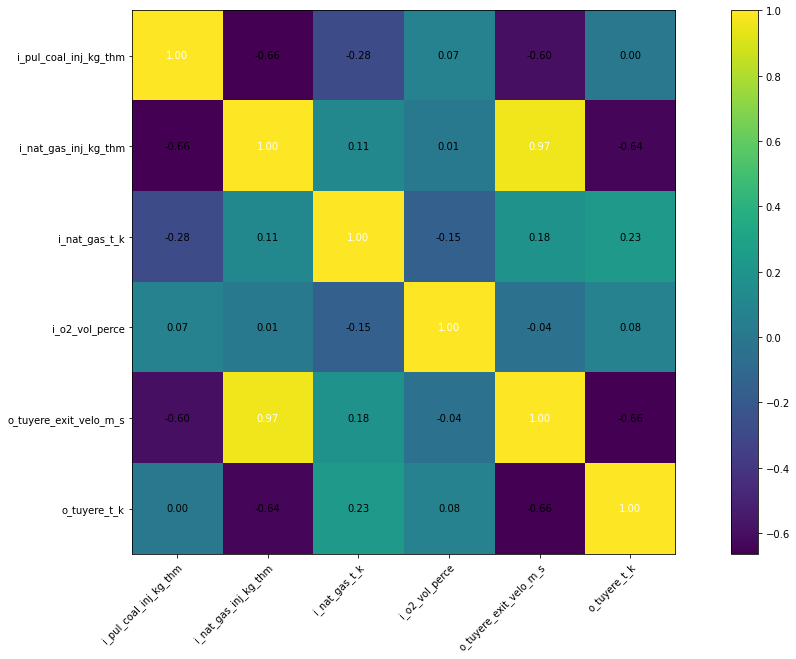

In [7]:
my_allInputs_section_names = ['i_pul_coal_inj_kg_thm','i_nat_gas_inj_kg_thm','i_nat_gas_t_k','i_o2_vol_perce',
                             'o_tuyere_exit_velo_m_s','o_tuyere_t_k']



cm = np.corrcoef(CFD_raw_data[my_allInputs_section_names].values.T)
hm = heatmap(cm, row_names=my_allInputs_section_names, column_names=my_allInputs_section_names, figsize=(20, 10))
plt.show()

In [8]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[  1.           0.          37.9        ...   0.1941631    0.0438327
    0.5448123 ]
 [  2.           0.          37.9        ...   0.2186134    0.04034286
    0.5149459 ]
 [  3.           0.          37.9        ...   0.2353341    0.03772617
    0.4849808 ]
 ...
 [394.         100.         150.         ...   0.2073243    0.1280017
    0.4297524 ]
 [395.         150.         100.         ...   0.1970337    0.1017694
    0.4325521 ]
 [396.         200.          50.         ...   0.2250411    0.07090925
    0.4464698 ]]
(396, 29)


In [9]:
#######################################################

input_indeces  = [1, 2, 3, 4]
output_indeces = [13, 14]                            

#######################################################

X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(396, 4)
(396, 2)
(316, 4)
(80, 4)
(316, 2)
(80, 2)


In [10]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

## Scale inputs (x)

In [11]:
###################################################################
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations

## Scale outputs (y)

In [12]:
###################################################################
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations

####################################################################

## Fit and DataLoader

In [13]:
def func_plot_performance(list_metric, the_string):
    
    list_samples = [i for i in range(len(list_metric))]
    
    plt.figure(figsize=(13,4))
    
    plt.scatter(list_samples, list_metric)
    
    ## plt.xlim(-1, 1)
    plt.ylim(-1, 1.5)
    
    plt.title('metric during training ' + the_string)
    plt.xlabel('iteration/epoch')
    plt.ylabel('R**2')
    ## plt.legend()
    
    file_name = '300dpiTuyere' + the_string + '.png'
    plt.savefig(file_name, dpi=300)

    plt.show()

In [14]:
#######################################################


def fit_y_scaled(num_epochs, model, loss_fn, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "No PDF shaping")
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [15]:
#######################################################


def fit_y_scaled_PDF(num_epochs, model, loss_fn, loss_fn_PDF, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            
            if epoch < int(num_epochs * switch_threshold):
                loss = loss_fn(pred_scaled, yb)
            else:
                opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )
                loss = loss_fn_PDF(pred_scaled, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "With PDF shaping")
            
         
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))
    
#######################################################

In [16]:
#######################################################
## define dataset

train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

#######################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


#######################################################

## Define NN architectures

In [17]:
#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 2) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(4, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 2)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################

In [18]:
#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(4, 2)       ## 2
        
        ## F2
        self.f2_linear1 = nn.Linear(4, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 2)       ## 2
        self.f2_dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################

## Impulse Function for PDF shaping

Uses a gaussian basically

In [19]:
def ImpulseGaussian(x, mu, sigma): 
   
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(sigma) )    )
    
    right = torch.exp(   -(x - mu)**2 / (2 * sigma)    )
    
    vector_vals = left * right
    
    return vector_vals         ## .unsqueeze(0)

## Kernel Density Estimation for PDF approximation

In [20]:
def kernel_density(x_range, the_errors, h): 
    
    x_range = x_range.unsqueeze(0)
   
    the_errors = the_errors.unsqueeze(2)
    
    
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
    
    right = torch.exp(   -((x_range - the_errors)/h)**2 / (2)    )
    
    vector_vals = left * right
    
    density         = torch.mean( vector_vals, 0) / h
             
    return density

## Custom loss function for PDF shaping

In [21]:
def my_loss(output, target):
    
    x = torch.arange(-N_error_range, N_error_range, 0.01)                        ## the error is in this range 
    
    error = output.float() - target.float() 
    
    basisFunc   =  kernel_density(x, error, h)
    
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)  
    
    diff = (  impulseFunc.float() - basisFunc.float()  )        ## * h         ## h is ?? 
    
    loss = torch.mean(   (   diff  )**2    )
    
    return loss

## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

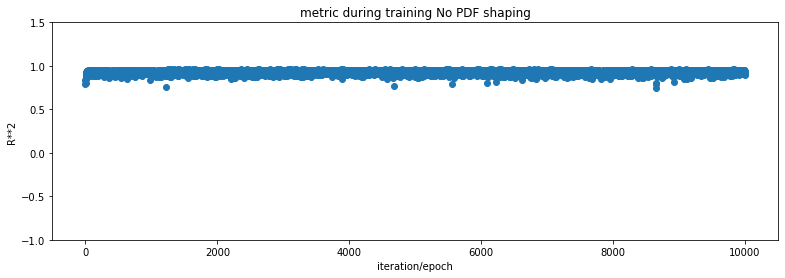

Training loss: tensor(0.0700, grad_fn=<MseLossBackward0>)
Training R**2: 0.9209448445135544
Test loss - scaled: tensor(0.0781, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(18.7812, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9323532736094582
Testing R**2 - descaled: 0.932353195468816


In [22]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

## Use model to predict

In [23]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])
        

**************************************************
preds, real
(128.63737, 128.57207)
(1439.5099, 1429.0322)
**************************************************
preds, real
(133.9845, 133.9054)
(1449.0491, 1444.46)
**************************************************
preds, real
(148.39778, 148.78258)
(1389.4371, 1381.8943)
**************************************************
preds, real
(128.04272, 128.05579)
(1429.0809, 1425.1986)
**************************************************
preds, real
(133.47452, 132.62503)
(1404.6505, 1425.9335)
**************************************************
preds, real
(131.48882, 132.331)
(1444.1453, 1447.5972)
**************************************************
preds, real
(129.0527, 128.67992)
(1417.8851, 1420.2968)
**************************************************
preds, real
(141.90787, 141.70135)
(1395.6423, 1392.966)
**************************************************
preds, real
(129.95418, 129.80739)
(1420.1843, 1420.4083)
***************************

## Plotting

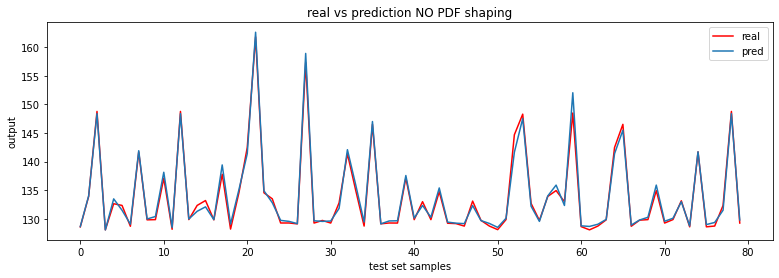

In [24]:
list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 2)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 2)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('Y0TuyereRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

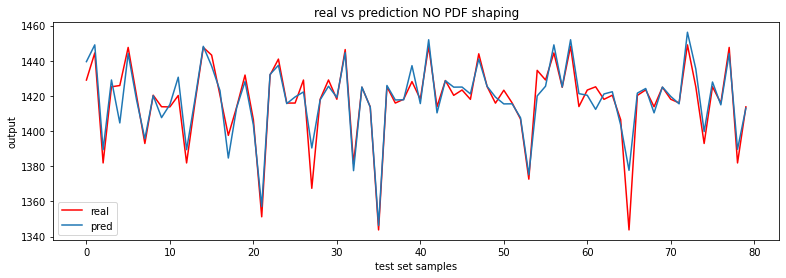

In [25]:
list_preds_y1 = [list_preds[i] for i in range(1, len(list_preds), 2)]
list_reals_y1 = [list_reals[i] for i in range(1, len(list_reals), 2)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y1, label= 'real', color='r' )
plt.plot(list_preds_y1, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('Y1TuyereRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()

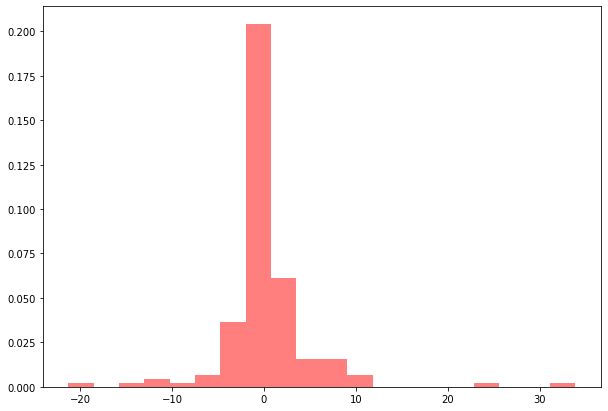

In [26]:
n_bins = 20

y_pred = np.array(list_preds)

y_real = np.array(list_reals)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)



plt.show()


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

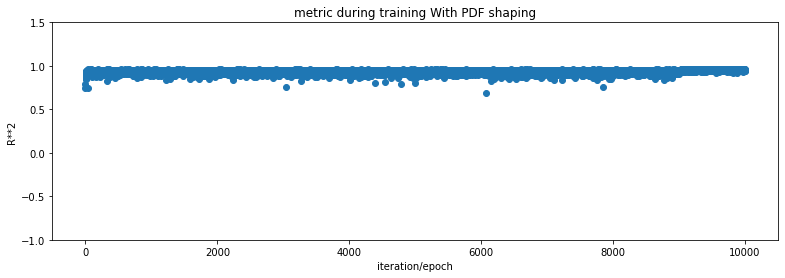

Training loss: tensor(0.0407, grad_fn=<MseLossBackward0>)
Training R**2: 0.9559953932732345
Test loss - scaled: tensor(0.0376, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(13.2157, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.9706111742940269
Testing R**2 - descaled: 0.9706111270953075


In [27]:

model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn     = F.mse_loss
loss_fn_PDF = my_loss

fit_y_scaled_PDF(N_EPOCHS, model, loss_fn, loss_fn_PDF, opt)

pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))


## Use model to predict

In [28]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])
        

**************************************************
preds, real
(128.86472, 128.57207)
(1424.798, 1429.0322)
**************************************************
preds, real
(134.1848, 133.9054)
(1443.9175, 1444.46)
**************************************************
preds, real
(149.15517, 148.78258)
(1389.0479, 1381.8943)
**************************************************
preds, real
(128.19875, 128.05579)
(1428.0986, 1425.1986)
**************************************************
preds, real
(132.92345, 132.62503)
(1404.9039, 1425.9335)
**************************************************
preds, real
(132.47151, 132.331)
(1452.8922, 1447.5972)
**************************************************
preds, real
(128.75797, 128.67992)
(1419.7731, 1420.2968)
**************************************************
preds, real
(141.68143, 141.70135)
(1401.8496, 1392.966)
**************************************************
preds, real
(129.42151, 129.80739)
(1422.0647, 1420.4083)
***************************

## Plotting

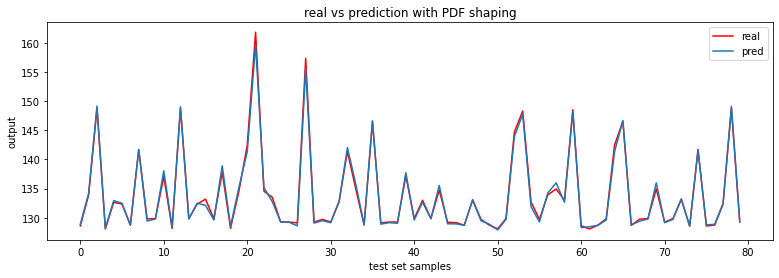

In [29]:

list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 2)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 2)]


plt.figure(figsize=(13,4))

plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction with PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('y0TuyereRealToPredictedWithPDFshaping.png', dpi=300)


plt.show()

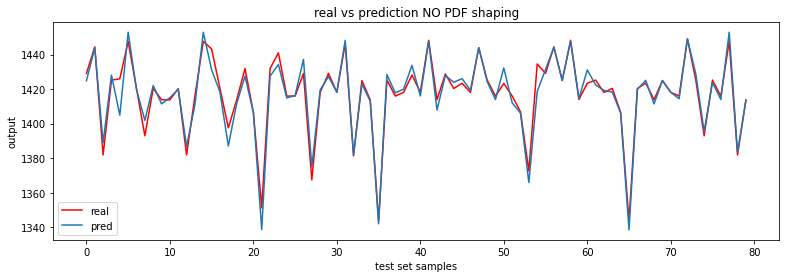

In [30]:

list_preds_y1 = [list_preds[i] for i in range(1, len(list_preds), 2)]
list_reals_y1 = [list_reals[i] for i in range(1, len(list_reals), 2)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y1, label= 'real', color='r' )
plt.plot(list_preds_y1, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('y1TuyereRealToPredictedWithPDFshaping.png', dpi=300)

plt.show()

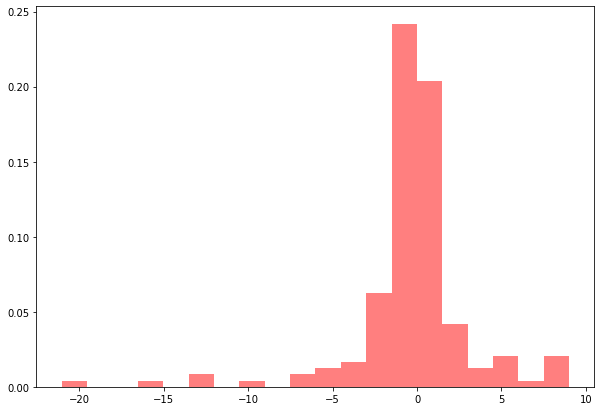

In [31]:

n_bins = 20

y_pred = np.array(list_preds)

y_real = np.array(list_reals)

error = y_pred - y_real


fig, ax = plt.subplots(figsize =(10, 7))

plt.hist(error, bins=n_bins, density = True, color='r', alpha=0.5)


plt.show()


In [33]:

'''

model.eval()

dummy_input = torch.randn(1, 4)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s396TuyerePDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''


'\n\nmodel.eval()\n\ndummy_input = torch.randn(1, 4)\n\n\ninput_names = ["input1"]\noutput_names = ["output1", "output2"]\n\ntorch.onnx.export(\n  model, \n  dummy_input, \n  "ONNXmodels/s396TuyerePDFshapingRC.onnx", \n  verbose=False, \n  input_names  = input_names,\n  output_names = output_names\n)\n\n'